In [1]:
from numpy import *

In [2]:
def NNMF(dataMat,a,maxCycles,e):
    V=mat(dataMat)
    n,m=shape(V)
    W=mat(random.random((n,a)))
    H=mat(random.random((a,m)))
    
    loss=[]
    for step in range(maxCycles):
        
        a=W.T*W*H
        a[where(a==0)]=1e-4
        H = multiply(H,W.T*V/a)
        
        b=W*H*H.T
        b[where(b==0)]=1e-4
        W = multiply(W,V*H.T/b)
        
        err = sum(multiply(V-W*H,V-W*H))
        
        loss.append(err)
        
        if err < e:
            break
        
        
    return W,H,loss

In [3]:
V = mat([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4]])

In [4]:
if __name__=='__main__':
    W,H,loss = NNMF(V,2,100,1e-5)
    print(W*H)

[[  5.25581156e+00   1.99313226e+00   1.45629159e-10   1.45515613e+00]
 [  3.50428894e+00   1.32891222e+00   7.37475889e-07   9.70220220e-01]
 [  1.31298407e+00   9.44165203e-01   1.94956107e+00   3.94602414e+00]
 [  9.81325836e-01   7.21804530e-01   1.52759147e+00   3.07879005e+00]
 [  8.30732536e-07   6.50094556e-01   2.84011145e+00   5.21897434e+00]]


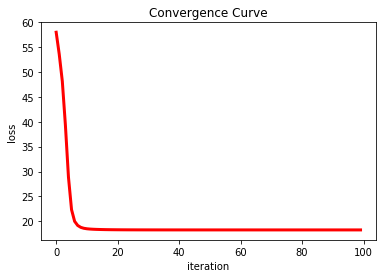

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

n=len(loss)
plt.plot(range(n),loss,color='r',linewidth=3)
plt.title('Convergence Curve')
plt.xlabel('iteration')
plt.ylabel('loss')

# The application of NMF in the term-document matrix

In [7]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
data=fetch_20newsgroups(remove=('headers','footers','quotes')).data

In [8]:
# convert the text to a tf-idf weighted term-document matrix
vectorizer=TfidfVectorizer(max_features=2000,min_df=10,stop_words='english')

X=vectorizer.fit_transform(data)

In [9]:
idx_to_word=array(vectorizer.get_feature_names())

In [10]:
#apply NMF
nmf=NMF(n_components=20,solver='mu')

In [11]:
W=nmf.fit_transform(X)

In [12]:
H=nmf.components_

In [13]:
#weight
W.shape

(11314, 20)

In [14]:
#components
H.shape

(20, 2000)

In [15]:
X.shape

(11314, 2000)

In [16]:
for i, topic in enumerate(H,1):
    print('Topic{}:{}'.format(i,','.join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic1:said,make,really,say,right,did,time,good,think,people
Topic2:information,appreciated,email,help,info,looking,hi,advance,mail,thanks
Topic3:lord,church,christians,christian,believe,faith,christ,bible,jesus,god
Topic4:public,algorithm,use,escrow,government,keys,clipper,encryption,chip,key
Topic5:mac,cd,floppy,controller,ide,hard,disk,drives,scsi,drive
Topic6:15,20,price,condition,offer,shipping,10,new,sale,00
Topic7:run,memory,screen,running,image,server,problem,using,program,use
Topic8:player,win,hockey,play,players,season,year,games,team,game
Topic9:ftp,article,cc,university,cs,soon,banks,gordon,pitt,edu
Topic10:new,oil,speed,dealer,miles,good,engine,cars,bike,car
Topic11:ram,color,driver,bus,vga,drivers,cards,monitor,video,card
Topic12:appreciated,new,work,program,doesn,help,mean,anybody,know,does
Topic13:wanted,oh,bike,work,thought,ll,wondering,got,ve,just
Topic14:running,os,version,nt,driver,microsoft,drivers,ms,dos,windows
Topic15:disk,gif,space,pub,format,zip,directory,ftp,